In [1]:
from jaxgym.ode import odedopri,  electron_equation_of_motion_DA
from jaxgym.field import schiske_lens_expansion_xyz, obtain_first_order_electrostatic_lens_properties
import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end, calculate_derivatives
from jaxgym.taylor import poly_dict, order_indices, poly_dict_to_sympy_expr

import jax
import jax.numpy as jnp
import numpy as np
import optimistix as optx

import tqdm

from scipy.constants import h as h_planck, e, m_e
from daceypy import array, DA
import sympy as sp
import os

from scipy.integrate import simpson
import matplotlib.pyplot as plt

jax.config.update("jax_platform_name", "gpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


%matplotlib widget

/home/dl277493/JaxTemGym/src/jaxgym/ode.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
X, Y, Z = sp.symbols('X Y Z')

scale = 1 #set to mm scale
# Set Parameters for Schiske Electrostatic Lens
# Define lens parameters

z_init = -0.015*scale  # Convert m to um units
a = 0.0004*scale  # Convert m to um units
phi_0 = 1000  # Volts

k = 0.4**(1/2)  # Unitless

(
    phi_expansion_symbolic,
    E_lambda, phi_lambda,
    phi_lambda_axial,
    phi_lambda_prime,
    phi_lambda_double_prime,
    phi_lambda_quadruple_prime,
    phi_lambda_sextuple_prime
) = schiske_lens_expansion_xyz(X, Y, Z, phi_0, a, k)

wavelength = h_planck/(2*abs(e)*m_e*phi_lambda_axial(z_init))**(1/2)*scale


z_pos, g, g_, h, h_, mag_real, z_image, z_focal_real, z_focal_asymp, z_pi = obtain_first_order_electrostatic_lens_properties(
    z_init, phi_lambda_axial, phi_lambda_prime, phi_lambda_double_prime, z_sampling=1000)

In [3]:
z_init = jnp.array(z_init, float)
z_image = jnp.array(z_image, float)

PointSource = comp.InputPlane(z=z_init)
ElectrostaticLens = comp.ODE(z=z_init, z_end=z_image, phi_lambda=phi_lambda, E_lambda=E_lambda)
Detector = comp.Detector(z=z_image, det_pixel_size=(5e-9 * scale, 5e-9 * scale), det_shape = (10, 10))
model = [PointSource, ElectrostaticLens, Detector]

det_coords = Detector.get_coords()

In [ ]:
import optax
from optax import apply_updates

sample_object = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
sample_object = sample_object[1:-1, 1:-1]  # Crop the image to remove borders
sample_shape = sample_object.shape

object_x = jnp.linspace(-1e-7, 1e-7, sample_shape[0])
object_y = jnp.linspace(-1e-7, 1e-7, sample_shape[1])
object_x, object_y = jnp.meshgrid(object_x, object_y)
object_x = object_x.ravel()
object_y = object_y.ravel()

x_det_shape, y_det_shape = Detector.det_shape

# flatten detector coordinates
x_det = det_coords[:, 0].ravel()
y_det = det_coords[:, 1].ravel()

@jax.jit
def run_to_end_matrix_wrapper(ray_matrix):
    
    ray = Ray(x=ray_matrix[0],
              y=ray_matrix[1],
              dx=ray_matrix[2],
              dy=ray_matrix[3],
              z=jnp.array(PointSource.z, float),
              pathlength=0.0,
              _one=1.0)
    
    ray = run_to_end(ray, model)

    ray_matrix_out = jnp.array([ray.x, ray.y, ray.dx, ray.dy]).T
    return ray_matrix_out, ray.pathlength

@jax.jit
def loss(tilts, positions, det_coords):

    tilts_x, tilts_y = tilts[:, 0], tilts[:, 1]
    positions_x, positions_y = positions[:, 0], positions[:, 1]

    ray_matrix = jnp.array([positions_x, positions_y, tilts_x, tilts_y]).T
    ray_matrix_out, _ = jax.vmap(run_to_end_matrix_wrapper)(ray_matrix)

    det_rays_x, det_rays_y, _, _ = ray_matrix_out.T
    
    rays_at_end = jnp.array([det_rays_x, det_rays_y]).T
    error = jnp.linalg.norm(det_coords - rays_at_end) 

    return error

det_coords = Detector.get_coords()
cur_tilts = jnp.zeros((det_coords.shape[0], 2))
#initialise to random tilts with 1e-3 max slope
cur_tilts = jax.random.uniform(jax.random.PRNGKey(0), shape=(det_coords.shape[0], 2), minval=-1e-3, maxval=1e-3)

cur_positions = jnp.zeros((det_coords.shape[0], 2))

results = {}
max_iterations = 1000
loss_val = 1.0

loss_history = []

adam_opt = optax.adam(learning_rate=1e-3)
adam_state = adam_opt.init(cur_tilts)

@jax.jit
def adam_step(cur_tilts, adam_state, cur_positions, det_coords):
    loss_val = loss(cur_tilts, cur_positions, det_coords)
    grads = jax.jacfwd(loss, argnums=0)(cur_tilts, cur_positions, det_coords)
    updates, adam_state = adam_opt.update(grads, adam_state, cur_tilts)
    cur_tilts = apply_updates(cur_tilts, updates)
    return cur_tilts, adam_state, loss_val

for i in tqdm.trange(max_iterations, desc="Adam Optimizer", leave=True):
    cur_tilts, adam_state, loss_val = adam_step(cur_tilts, adam_state, cur_positions, det_coords)
    loss_history.append(loss_val)
    print(loss_val)
    if loss_val < 1e-9:
        break

results["adam"] = loss_history

plt.figure()
for opt_name, history in results.items():
    plt.plot(history, label=opt_name)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs Iteration')
plt.legend()
plt.grid(True)
plt.show()



Adam Optimizer:   0%|          | 1/1000 [00:05<1:24:08,  5.05s/it]

9.760328956835573e-07


Adam Optimizer:   0%|          | 2/1000 [00:05<37:07,  2.23s/it]  

1.326204130175946e-06


Adam Optimizer:   0%|          | 3/1000 [00:05<22:04,  1.33s/it]

1.3733831557971794e-06


Adam Optimizer:   0%|          | 4/1000 [00:05<14:59,  1.11it/s]

1.2432836550980118e-06


Adam Optimizer:   0%|          | 5/1000 [00:06<11:03,  1.50it/s]

9.591771870392426e-07


Adam Optimizer:   1%|          | 6/1000 [00:06<08:40,  1.91it/s]

8.451670234743631e-07


Adam Optimizer:   1%|          | 7/1000 [00:06<07:09,  2.31it/s]

6.971022815056095e-07


Adam Optimizer:   1%|          | 8/1000 [00:06<06:07,  2.70it/s]

5.193872463530637e-07


Adam Optimizer:   1%|          | 9/1000 [00:07<05:18,  3.11it/s]

4.990546586029939e-07


Adam Optimizer:   1%|          | 10/1000 [00:07<04:45,  3.46it/s]

5.726162434808552e-07


Adam Optimizer:   1%|          | 11/1000 [00:07<04:23,  3.75it/s]

5.108466746983843e-07


Adam Optimizer:   1%|          | 12/1000 [00:07<04:07,  3.99it/s]

3.724987563178083e-07


Adam Optimizer:   1%|▏         | 13/1000 [00:07<03:55,  4.18it/s]

3.4237568776540824e-07


Adam Optimizer:   1%|▏         | 14/1000 [00:08<03:48,  4.31it/s]

3.568565551828964e-07


Adam Optimizer:   2%|▏         | 15/1000 [00:08<03:42,  4.42it/s]

3.0980442903587503e-07


Adam Optimizer:   2%|▏         | 16/1000 [00:08<03:39,  4.49it/s]

2.4432267057022576e-07


Adam Optimizer:   2%|▏         | 17/1000 [00:08<03:36,  4.55it/s]

2.293926797778997e-07


Adam Optimizer:   2%|▏         | 18/1000 [00:08<03:34,  4.59it/s]

2.3608682392120766e-07


Adam Optimizer:   2%|▏         | 19/1000 [00:09<03:32,  4.62it/s]

2.4230841212742093e-07


Adam Optimizer:   2%|▏         | 20/1000 [00:09<03:31,  4.64it/s]

2.5145336767115373e-07


Adam Optimizer:   2%|▏         | 21/1000 [00:09<03:30,  4.66it/s]

2.397042955209184e-07


Adam Optimizer:   2%|▏         | 22/1000 [00:09<03:29,  4.67it/s]

2.1652076349388686e-07


Adam Optimizer:   2%|▏         | 23/1000 [00:09<03:28,  4.68it/s]

2.161678093676394e-07


Adam Optimizer:   2%|▏         | 24/1000 [00:10<03:28,  4.69it/s]

2.1096523844553642e-07


Adam Optimizer:   2%|▎         | 25/1000 [00:10<03:27,  4.71it/s]

1.9506050495285937e-07


Adam Optimizer:   3%|▎         | 26/1000 [00:10<03:26,  4.71it/s]

1.8382644322474626e-07


Adam Optimizer:   3%|▎         | 27/1000 [00:10<03:26,  4.71it/s]

1.7371569816818623e-07


Adam Optimizer:   3%|▎         | 28/1000 [00:11<03:26,  4.70it/s]

1.7647424008189524e-07


Adam Optimizer:   3%|▎         | 29/1000 [00:11<03:25,  4.72it/s]

1.679242806725128e-07


Adam Optimizer:   3%|▎         | 30/1000 [00:11<03:25,  4.73it/s]

1.689581991862271e-07


Adam Optimizer:   3%|▎         | 31/1000 [00:11<03:24,  4.73it/s]

1.586897435207719e-07


Adam Optimizer:   3%|▎         | 32/1000 [00:11<03:25,  4.71it/s]

1.5733922746448815e-07


Adam Optimizer:   3%|▎         | 33/1000 [00:12<03:25,  4.71it/s]

1.6170128621440837e-07


Adam Optimizer:   3%|▎         | 34/1000 [00:12<03:24,  4.72it/s]

1.4447372655435608e-07


Adam Optimizer:   4%|▎         | 35/1000 [00:12<03:24,  4.72it/s]

1.4696819683596391e-07


Adam Optimizer:   4%|▎         | 36/1000 [00:12<03:24,  4.71it/s]

1.3934139587514603e-07


Adam Optimizer:   4%|▎         | 37/1000 [00:12<03:24,  4.71it/s]

1.3517084161501227e-07


Adam Optimizer:   4%|▍         | 38/1000 [00:13<03:24,  4.69it/s]

1.371728989121718e-07


Adam Optimizer:   4%|▍         | 39/1000 [00:13<03:23,  4.71it/s]

1.2613622068231232e-07


Adam Optimizer:   4%|▍         | 40/1000 [00:13<03:23,  4.71it/s]

1.2314495954366473e-07


Adam Optimizer:   4%|▍         | 41/1000 [00:13<03:23,  4.71it/s]

1.3891028778040317e-07


Adam Optimizer:   4%|▍         | 42/1000 [00:14<03:23,  4.72it/s]

1.090286301681729e-07


Adam Optimizer:   4%|▍         | 43/1000 [00:14<03:22,  4.72it/s]

1.0895081332828246e-07


Adam Optimizer:   4%|▍         | 44/1000 [00:14<03:23,  4.71it/s]

1.1311519784500662e-07


Adam Optimizer:   4%|▍         | 45/1000 [00:14<03:23,  4.69it/s]

1.0811127482966939e-07


Adam Optimizer:   5%|▍         | 46/1000 [00:14<03:22,  4.70it/s]

1.0322429498804078e-07


Adam Optimizer:   5%|▍         | 47/1000 [00:15<03:22,  4.70it/s]

1.0433114412876945e-07


Adam Optimizer:   5%|▍         | 48/1000 [00:15<03:22,  4.71it/s]

1.0185384441482198e-07


Adam Optimizer:   5%|▍         | 49/1000 [00:15<03:21,  4.71it/s]

1.0355901295750826e-07


Adam Optimizer:   5%|▌         | 50/1000 [00:15<03:22,  4.70it/s]

1.1196017784179467e-07


Adam Optimizer:   5%|▌         | 51/1000 [00:15<03:21,  4.71it/s]

1.0482040730279062e-07


Adam Optimizer:   5%|▌         | 52/1000 [00:16<03:21,  4.71it/s]

9.992898831591709e-08


Adam Optimizer:   5%|▌         | 53/1000 [00:16<03:21,  4.69it/s]

1.0190487583427986e-07


Adam Optimizer:   5%|▌         | 54/1000 [00:16<03:21,  4.70it/s]

9.977041131097467e-08


Adam Optimizer:   6%|▌         | 55/1000 [00:16<03:20,  4.71it/s]

1.2390201909988724e-07


Adam Optimizer:   6%|▌         | 56/1000 [00:17<03:20,  4.72it/s]

9.372636009032803e-08


Adam Optimizer:   6%|▌         | 57/1000 [00:17<03:19,  4.73it/s]

9.537109013363286e-08


Adam Optimizer:   6%|▌         | 58/1000 [00:17<03:18,  4.73it/s]

1.453976650018275e-07


Adam Optimizer:   6%|▌         | 59/1000 [00:17<03:18,  4.74it/s]

9.848511578604203e-08


Adam Optimizer:   6%|▌         | 60/1000 [00:17<03:17,  4.75it/s]

8.835229981822355e-08


Adam Optimizer:   6%|▌         | 61/1000 [00:18<03:18,  4.74it/s]

1.507361246652119e-07


Adam Optimizer:   6%|▌         | 62/1000 [00:18<03:17,  4.74it/s]

8.571404168670979e-08


Adam Optimizer:   6%|▋         | 63/1000 [00:18<03:17,  4.75it/s]

9.542025009078605e-08


Adam Optimizer:   6%|▋         | 64/1000 [00:18<03:16,  4.76it/s]

9.354157854208206e-08


Adam Optimizer:   6%|▋         | 65/1000 [00:18<03:17,  4.73it/s]

1.2545676082608613e-07


Adam Optimizer:   7%|▋         | 66/1000 [00:19<03:17,  4.74it/s]

1.3009098142386818e-07


Adam Optimizer:   7%|▋         | 67/1000 [00:19<03:17,  4.73it/s]

1.4346264681137392e-07


Adam Optimizer:   7%|▋         | 68/1000 [00:19<03:17,  4.72it/s]

8.706632261279257e-08


Adam Optimizer:   7%|▋         | 69/1000 [00:19<03:17,  4.72it/s]

9.589586211233703e-08


Adam Optimizer:   7%|▋         | 70/1000 [00:19<03:17,  4.72it/s]

1.177504373153269e-07


Adam Optimizer:   7%|▋         | 71/1000 [00:20<03:17,  4.71it/s]

8.13626742576502e-08


Adam Optimizer:   7%|▋         | 72/1000 [00:20<03:16,  4.73it/s]

1.0807225813915348e-07


Adam Optimizer:   7%|▋         | 73/1000 [00:20<03:16,  4.73it/s]

1.410860418381395e-07


Adam Optimizer:   7%|▋         | 74/1000 [00:20<03:15,  4.74it/s]

8.668564150878066e-08


Adam Optimizer:   8%|▊         | 75/1000 [00:21<03:14,  4.75it/s]

8.539763758999826e-08


Adam Optimizer:   8%|▊         | 76/1000 [00:21<03:15,  4.72it/s]

1.5510862950526677e-07


Adam Optimizer:   8%|▊         | 77/1000 [00:21<03:15,  4.73it/s]

1.1737451670904045e-07


Adam Optimizer:   8%|▊         | 78/1000 [00:21<03:14,  4.75it/s]

9.374549963754518e-08


Adam Optimizer:   8%|▊         | 79/1000 [00:21<03:14,  4.74it/s]

1.0222451924723341e-07


Adam Optimizer:   8%|▊         | 80/1000 [00:22<03:14,  4.73it/s]

1.4645360008065712e-07


Adam Optimizer:   8%|▊         | 81/1000 [00:22<03:14,  4.72it/s]

9.689769567821473e-08


Adam Optimizer:   8%|▊         | 82/1000 [00:22<03:14,  4.73it/s]

1.103090394756206e-07


Adam Optimizer:   8%|▊         | 83/1000 [00:22<03:14,  4.72it/s]

1.603508287996666e-07


Adam Optimizer:   8%|▊         | 84/1000 [00:22<03:13,  4.73it/s]

1.0554428082970699e-07


Adam Optimizer:   8%|▊         | 85/1000 [00:23<03:13,  4.74it/s]

8.363248472566858e-08


Adam Optimizer:   9%|▊         | 86/1000 [00:23<03:13,  4.72it/s]

1.4257090190512638e-07


Adam Optimizer:   9%|▊         | 87/1000 [00:23<03:13,  4.72it/s]

8.86576137239127e-08


Adam Optimizer:   9%|▉         | 88/1000 [00:23<03:12,  4.73it/s]

6.446715568279134e-08


Adam Optimizer:   9%|▉         | 89/1000 [00:23<03:12,  4.74it/s]

8.786119568933347e-08


Adam Optimizer:   9%|▉         | 90/1000 [00:24<03:11,  4.75it/s]

1.2076300733769335e-07


Adam Optimizer:   9%|▉         | 91/1000 [00:24<03:11,  4.75it/s]

1.0933139305752771e-07


Adam Optimizer:   9%|▉         | 92/1000 [00:24<03:11,  4.74it/s]

1.0304528576080374e-07


Adam Optimizer:   9%|▉         | 93/1000 [00:24<03:12,  4.72it/s]

9.723353402600887e-08


Adam Optimizer:   9%|▉         | 94/1000 [00:25<03:11,  4.74it/s]

7.470769070229156e-08


Adam Optimizer:  10%|▉         | 95/1000 [00:25<03:11,  4.73it/s]

1.1756272042879847e-07


Adam Optimizer:  10%|▉         | 96/1000 [00:25<03:10,  4.74it/s]

1.0124248265918997e-07


Adam Optimizer:  10%|▉         | 97/1000 [00:25<03:10,  4.75it/s]

8.5445257111004e-08


Adam Optimizer:  10%|▉         | 98/1000 [00:25<03:09,  4.75it/s]

8.895107809991303e-08


Adam Optimizer:  10%|▉         | 99/1000 [00:26<03:10,  4.74it/s]

1.554412343183421e-07


Adam Optimizer:  10%|█         | 100/1000 [00:26<03:09,  4.75it/s]

9.889393776076543e-08


Adam Optimizer:  10%|█         | 101/1000 [00:26<03:09,  4.76it/s]

8.431632258609364e-08


Adam Optimizer:  10%|█         | 102/1000 [00:26<03:08,  4.76it/s]

1.1145008814465311e-07


Adam Optimizer:  10%|█         | 103/1000 [00:26<03:08,  4.75it/s]

1.0026200932351798e-07


Adam Optimizer:  10%|█         | 104/1000 [00:27<03:08,  4.75it/s]

7.863884819836757e-08


Adam Optimizer:  10%|█         | 105/1000 [00:27<03:08,  4.75it/s]

1.0799556525733674e-07


Adam Optimizer:  11%|█         | 106/1000 [00:27<03:08,  4.73it/s]

9.919885623886068e-08


Adam Optimizer:  11%|█         | 107/1000 [00:27<03:08,  4.74it/s]

1.1249245725601416e-07


Adam Optimizer:  11%|█         | 108/1000 [00:27<03:08,  4.72it/s]

1.0028708572542826e-07


Adam Optimizer:  11%|█         | 109/1000 [00:28<03:10,  4.68it/s]

2.1872543104990498e-07


Adam Optimizer:  11%|█         | 110/1000 [00:28<03:10,  4.67it/s]

1.6367566588466087e-07


Adam Optimizer:  11%|█         | 111/1000 [00:28<03:09,  4.70it/s]

9.57938004333698e-08


Adam Optimizer:  11%|█         | 112/1000 [00:28<03:10,  4.66it/s]

2.499152867370456e-07


Adam Optimizer:  11%|█▏        | 113/1000 [00:29<03:11,  4.63it/s]

2.0752049452470296e-07


Adam Optimizer:  11%|█▏        | 114/1000 [00:29<03:09,  4.67it/s]

8.837256998071073e-08


Adam Optimizer:  12%|█▏        | 115/1000 [00:29<03:08,  4.69it/s]

1.2792815820567143e-07


Adam Optimizer:  12%|█▏        | 116/1000 [00:29<03:09,  4.67it/s]

2.591627113898923e-07


Adam Optimizer:  12%|█▏        | 117/1000 [00:29<03:08,  4.67it/s]

1.2305640316692806e-07


Adam Optimizer:  12%|█▏        | 118/1000 [00:30<03:07,  4.70it/s]

9.939955346371184e-08


Adam Optimizer:  12%|█▏        | 119/1000 [00:30<03:06,  4.72it/s]

8.038093068579081e-08


Adam Optimizer:  12%|█▏        | 120/1000 [00:30<03:07,  4.68it/s]

1.7777614407247472e-07


Adam Optimizer:  12%|█▏        | 121/1000 [00:30<03:07,  4.69it/s]

1.4618018709509985e-07


Adam Optimizer:  12%|█▏        | 122/1000 [00:30<03:07,  4.69it/s]

8.707677976003503e-08


Adam Optimizer:  12%|█▏        | 123/1000 [00:31<03:06,  4.71it/s]

7.506170669635862e-08


Adam Optimizer:  12%|█▏        | 124/1000 [00:31<03:05,  4.72it/s]

9.150676575530314e-08


Adam Optimizer:  12%|█▎        | 125/1000 [00:31<03:04,  4.73it/s]

8.625415041740455e-08


Adam Optimizer:  13%|█▎        | 126/1000 [00:31<03:04,  4.74it/s]

1.1378896485202534e-07


Adam Optimizer:  13%|█▎        | 127/1000 [00:32<03:04,  4.74it/s]

1.366758880933425e-07


Adam Optimizer:  13%|█▎        | 128/1000 [00:32<03:03,  4.74it/s]

1.1155822048272789e-07


Adam Optimizer:  13%|█▎        | 129/1000 [00:32<03:03,  4.75it/s]

7.605850270585778e-08


Adam Optimizer:  13%|█▎        | 130/1000 [00:32<03:04,  4.73it/s]

9.802169396724622e-08


Adam Optimizer:  13%|█▎        | 131/1000 [00:32<03:03,  4.74it/s]

8.262558839250005e-08


Adam Optimizer:  13%|█▎        | 132/1000 [00:33<03:05,  4.69it/s]

3.505777496777865e-07


Adam Optimizer:  13%|█▎        | 133/1000 [00:33<03:04,  4.69it/s]

1.8322420077830727e-07


Adam Optimizer:  13%|█▎        | 134/1000 [00:33<03:04,  4.69it/s]

1.0284679419181978e-07


Adam Optimizer:  14%|█▎        | 135/1000 [00:33<03:06,  4.63it/s]

4.464102643357559e-07


Adam Optimizer:  14%|█▎        | 136/1000 [00:33<03:08,  4.58it/s]

4.1595156172386765e-07


Adam Optimizer:  14%|█▎        | 137/1000 [00:34<03:06,  4.62it/s]

8.522641327410333e-08


Adam Optimizer:  14%|█▍        | 138/1000 [00:34<03:05,  4.66it/s]

1.2648554401373133e-07


Adam Optimizer:  14%|█▍        | 139/1000 [00:34<03:05,  4.64it/s]

3.8117901450621346e-07


Adam Optimizer:  14%|█▍        | 140/1000 [00:34<03:06,  4.60it/s]

3.36859488677418e-07


Adam Optimizer:  14%|█▍        | 141/1000 [00:35<03:05,  4.63it/s]

1.4674216315324175e-07


Adam Optimizer:  14%|█▍        | 142/1000 [00:35<03:04,  4.65it/s]

1.099245111902826e-07


Adam Optimizer:  14%|█▍        | 143/1000 [00:35<03:03,  4.67it/s]

1.2207369376054965e-07


Adam Optimizer:  14%|█▍        | 144/1000 [00:35<03:02,  4.69it/s]

1.003346001750351e-07


Adam Optimizer:  14%|█▍        | 145/1000 [00:35<03:02,  4.67it/s]

1.7408741060293046e-07


Adam Optimizer:  15%|█▍        | 146/1000 [00:36<03:02,  4.68it/s]

1.1236984552656008e-07


Adam Optimizer:  15%|█▍        | 147/1000 [00:36<03:01,  4.69it/s]

1.3834744753207533e-07


Adam Optimizer:  15%|█▍        | 148/1000 [00:36<03:01,  4.69it/s]

9.92936165665869e-08


Adam Optimizer:  15%|█▍        | 149/1000 [00:36<03:03,  4.64it/s]

2.812821743774237e-07


Adam Optimizer:  15%|█▌        | 150/1000 [00:36<03:01,  4.67it/s]

7.727993099537053e-08


Adam Optimizer:  15%|█▌        | 151/1000 [00:37<03:00,  4.70it/s]

1.0841430018401875e-07


Adam Optimizer:  15%|█▌        | 152/1000 [00:37<03:02,  4.66it/s]

3.2321509115922243e-07


Adam Optimizer:  15%|█▌        | 153/1000 [00:37<03:01,  4.67it/s]

1.110578401896661e-07


Adam Optimizer:  15%|█▌        | 154/1000 [00:37<02:59,  4.70it/s]

9.6470644844756e-08


Adam Optimizer:  16%|█▌        | 155/1000 [00:38<02:59,  4.71it/s]

1.3800308600361415e-07


Adam Optimizer:  16%|█▌        | 156/1000 [00:38<03:00,  4.68it/s]

1.8804141268757073e-07


Adam Optimizer:  16%|█▌        | 157/1000 [00:38<02:59,  4.70it/s]

8.429605966476589e-08


Adam Optimizer:  16%|█▌        | 158/1000 [00:38<02:58,  4.73it/s]

6.669805083296406e-08


Adam Optimizer:  16%|█▌        | 159/1000 [00:38<02:58,  4.72it/s]

6.466059222610278e-08


Adam Optimizer:  16%|█▌        | 160/1000 [00:39<02:57,  4.73it/s]

9.879087337134626e-08


Adam Optimizer:  16%|█▌        | 161/1000 [00:39<02:57,  4.73it/s]

1.2226576457698887e-07


Adam Optimizer:  16%|█▌        | 162/1000 [00:39<03:02,  4.60it/s]

1.0248826018729176e-07


Adam Optimizer:  16%|█▋        | 163/1000 [00:39<03:11,  4.38it/s]

2.7374506704017453e-07


Adam Optimizer:  16%|█▋        | 164/1000 [00:40<03:17,  4.24it/s]

1.9362764389367672e-07


Adam Optimizer:  16%|█▋        | 165/1000 [00:40<03:18,  4.20it/s]

5.595306433479197e-07


Adam Optimizer:  17%|█▋        | 166/1000 [00:40<03:14,  4.28it/s]

5.764564835903177e-07


Adam Optimizer:  17%|█▋        | 167/1000 [00:40<03:10,  4.38it/s]

1.0573874340037463e-07


Adam Optimizer:  17%|█▋        | 168/1000 [00:40<03:06,  4.46it/s]

9.064896305039717e-08


Adam Optimizer:  17%|█▋        | 169/1000 [00:41<03:06,  4.46it/s]

4.086452264332144e-07


Adam Optimizer:  17%|█▋        | 170/1000 [00:41<03:05,  4.47it/s]

4.421431777329807e-07


Adam Optimizer:  17%|█▋        | 171/1000 [00:41<03:03,  4.52it/s]

1.3586804435100467e-07


Adam Optimizer:  17%|█▋        | 172/1000 [00:41<03:00,  4.58it/s]

7.076444203935328e-08


Adam Optimizer:  17%|█▋        | 173/1000 [00:42<02:59,  4.61it/s]

9.673935317429643e-08


Adam Optimizer:  17%|█▋        | 174/1000 [00:42<02:58,  4.64it/s]

1.5145420327149068e-07


Adam Optimizer:  18%|█▊        | 175/1000 [00:42<02:58,  4.62it/s]

3.8180633089151295e-07


Adam Optimizer:  18%|█▊        | 176/1000 [00:42<02:59,  4.58it/s]

2.7915769609498455e-07


Adam Optimizer:  18%|█▊        | 177/1000 [00:42<03:00,  4.56it/s]

2.885330376988386e-07


Adam Optimizer:  18%|█▊        | 178/1000 [00:43<02:59,  4.59it/s]

1.2141997685548533e-07


Adam Optimizer:  18%|█▊        | 179/1000 [00:43<02:59,  4.58it/s]

1.9293312377660138e-07


Adam Optimizer:  18%|█▊        | 180/1000 [00:43<02:59,  4.56it/s]

3.6310154254135607e-07


Adam Optimizer:  18%|█▊        | 181/1000 [00:43<02:59,  4.57it/s]

2.1868180701982853e-07


Adam Optimizer:  18%|█▊        | 182/1000 [00:43<02:58,  4.57it/s]

2.4148614879416933e-07


Adam Optimizer:  18%|█▊        | 183/1000 [00:44<02:59,  4.55it/s]

3.2394336095273026e-07


Adam Optimizer:  18%|█▊        | 184/1000 [00:44<02:59,  4.56it/s]

2.048993992940418e-07


Adam Optimizer:  18%|█▊        | 185/1000 [00:44<02:59,  4.54it/s]

3.753990139433962e-07


Adam Optimizer:  19%|█▊        | 186/1000 [00:44<02:58,  4.56it/s]

1.4501447489119558e-07


Adam Optimizer:  19%|█▊        | 187/1000 [00:45<02:56,  4.60it/s]

1.4128183135596944e-07


Adam Optimizer:  19%|█▉        | 188/1000 [00:45<02:56,  4.61it/s]

1.7005296465042585e-07


Adam Optimizer:  19%|█▉        | 189/1000 [00:45<02:56,  4.60it/s]

2.2571576383566817e-07


Adam Optimizer:  19%|█▉        | 190/1000 [00:45<02:55,  4.61it/s]

1.3525028324275458e-07


Adam Optimizer:  19%|█▉        | 191/1000 [00:45<02:54,  4.65it/s]

8.289033906949211e-08


Adam Optimizer:  19%|█▉        | 192/1000 [00:46<02:53,  4.66it/s]

8.941074138090543e-08


Adam Optimizer:  19%|█▉        | 193/1000 [00:46<02:53,  4.65it/s]

1.019533906841357e-07


Adam Optimizer:  19%|█▉        | 194/1000 [00:46<02:54,  4.62it/s]

1.7300344304558972e-07


Adam Optimizer:  20%|█▉        | 195/1000 [00:46<02:53,  4.64it/s]

7.77721712744034e-08


Adam Optimizer:  20%|█▉        | 196/1000 [00:47<02:52,  4.66it/s]

7.256513583138975e-08


Adam Optimizer:  20%|█▉        | 197/1000 [00:47<02:52,  4.66it/s]

1.0152027430718984e-07


Adam Optimizer:  20%|█▉        | 198/1000 [00:47<02:52,  4.66it/s]

1.2236442871029924e-07


Adam Optimizer:  20%|█▉        | 199/1000 [00:47<02:52,  4.66it/s]

9.428435682563239e-08


Adam Optimizer:  20%|██        | 200/1000 [00:47<02:52,  4.63it/s]

1.9451963570616303e-07


Adam Optimizer:  20%|██        | 201/1000 [00:48<02:51,  4.65it/s]

9.303458527003724e-08


Adam Optimizer:  20%|██        | 202/1000 [00:48<02:53,  4.60it/s]

2.5120784940037026e-07


Adam Optimizer:  20%|██        | 203/1000 [00:48<02:52,  4.63it/s]

9.072149496460818e-08


Adam Optimizer:  20%|██        | 204/1000 [00:48<02:51,  4.65it/s]

6.946741518362785e-08


Adam Optimizer:  20%|██        | 205/1000 [00:48<02:52,  4.62it/s]

2.6220591663201683e-07


Adam Optimizer:  21%|██        | 206/1000 [00:49<02:52,  4.60it/s]

1.8294650177360418e-07


Adam Optimizer:  21%|██        | 207/1000 [00:49<02:53,  4.57it/s]

2.3065473632262386e-07


Adam Optimizer:  21%|██        | 208/1000 [00:49<02:52,  4.58it/s]

1.4673941018469644e-07


Adam Optimizer:  21%|██        | 209/1000 [00:49<02:51,  4.61it/s]

1.459428679226738e-07


Adam Optimizer:  21%|██        | 210/1000 [00:50<02:51,  4.62it/s]

1.3054943114518787e-07


Adam Optimizer:  21%|██        | 211/1000 [00:50<02:50,  4.63it/s]

1.4177185240144878e-07


Adam Optimizer:  21%|██        | 212/1000 [00:50<02:49,  4.65it/s]

1.0905111977578695e-07


Adam Optimizer:  21%|██▏       | 213/1000 [00:50<02:48,  4.66it/s]

9.359729969497256e-08


Adam Optimizer:  21%|██▏       | 214/1000 [00:50<02:48,  4.68it/s]

7.299072840952332e-08


Adam Optimizer:  22%|██▏       | 215/1000 [00:51<02:47,  4.68it/s]

9.604828651785918e-08


Adam Optimizer:  22%|██▏       | 216/1000 [00:51<02:47,  4.67it/s]

1.0485152131982475e-07


Adam Optimizer:  22%|██▏       | 217/1000 [00:51<02:47,  4.66it/s]

1.0608724781978547e-07


Adam Optimizer:  22%|██▏       | 218/1000 [00:51<02:47,  4.68it/s]

7.625831979478936e-08


Adam Optimizer:  22%|██▏       | 219/1000 [00:51<02:46,  4.69it/s]

7.188822349977672e-08


Adam Optimizer:  22%|██▏       | 220/1000 [00:52<02:46,  4.70it/s]

6.645748235388479e-08


Adam Optimizer:  22%|██▏       | 221/1000 [00:52<02:45,  4.70it/s]

8.285859696025705e-08


Adam Optimizer:  22%|██▏       | 222/1000 [00:52<02:45,  4.69it/s]

9.13559817296506e-08


Adam Optimizer:  22%|██▏       | 223/1000 [00:52<02:48,  4.61it/s]

2.5825319707310453e-07


Adam Optimizer:  22%|██▏       | 224/1000 [00:53<02:51,  4.54it/s]

5.360941798170338e-07


Adam Optimizer:  22%|██▎       | 225/1000 [00:53<02:54,  4.44it/s]

9.96271178476787e-07


Adam Optimizer:  23%|██▎       | 226/1000 [00:53<02:55,  4.40it/s]

7.221468069541627e-07


Adam Optimizer:  23%|██▎       | 227/1000 [00:53<02:54,  4.42it/s]

1.9566438938331352e-07


Adam Optimizer:  23%|██▎       | 228/1000 [00:53<02:55,  4.41it/s]

7.268560777937235e-07


Adam Optimizer:  23%|██▎       | 229/1000 [00:54<02:54,  4.41it/s]

4.438357505217665e-07


Adam Optimizer:  23%|██▎       | 230/1000 [00:54<02:55,  4.40it/s]

6.571220344796145e-07


Adam Optimizer:  23%|██▎       | 231/1000 [00:54<02:53,  4.43it/s]

2.1220862738085207e-07


Adam Optimizer:  23%|██▎       | 232/1000 [00:54<02:51,  4.47it/s]

1.1246447626560875e-07


Adam Optimizer:  23%|██▎       | 233/1000 [00:55<02:51,  4.48it/s]

2.8734402221273705e-07


Adam Optimizer:  23%|██▎       | 234/1000 [00:55<02:50,  4.48it/s]

3.7128107913265375e-07


Adam Optimizer:  24%|██▎       | 235/1000 [00:55<02:51,  4.47it/s]

4.3664892068895027e-07


Adam Optimizer:  24%|██▎       | 236/1000 [00:55<02:49,  4.51it/s]

1.3841030115718818e-07


Adam Optimizer:  24%|██▎       | 237/1000 [00:55<02:48,  4.54it/s]

5.4741331772925416e-08


Adam Optimizer:  24%|██▍       | 238/1000 [00:56<02:46,  4.57it/s]

6.094131774595878e-08


Adam Optimizer:  24%|██▍       | 239/1000 [00:56<02:46,  4.57it/s]

1.266492872241208e-07


Adam Optimizer:  24%|██▍       | 240/1000 [00:56<02:47,  4.55it/s]

2.4238698898566e-07


Adam Optimizer:  24%|██▍       | 241/1000 [00:56<02:46,  4.55it/s]

2.000451295179799e-07


Adam Optimizer:  24%|██▍       | 242/1000 [00:57<02:44,  4.60it/s]

1.243416894733834e-07


Adam Optimizer:  24%|██▍       | 243/1000 [00:57<02:43,  4.63it/s]

8.935577266061337e-08


Adam Optimizer:  24%|██▍       | 244/1000 [00:57<02:42,  4.65it/s]

8.36673078728667e-08


Adam Optimizer:  24%|██▍       | 245/1000 [00:57<02:43,  4.62it/s]

9.432653111830988e-08


Adam Optimizer:  25%|██▍       | 246/1000 [00:57<02:44,  4.58it/s]

2.538382766831654e-07


Adam Optimizer:  25%|██▍       | 247/1000 [00:58<02:43,  4.60it/s]

1.2613791103486042e-07


Adam Optimizer:  25%|██▍       | 248/1000 [00:58<02:46,  4.52it/s]

9.055835978458942e-07


Adam Optimizer:  25%|██▍       | 249/1000 [00:58<02:45,  4.52it/s]

1.4171637494634232e-07


Adam Optimizer:  25%|██▌       | 250/1000 [00:58<02:44,  4.55it/s]

1.4660725319494564e-07


Adam Optimizer:  25%|██▌       | 251/1000 [00:59<02:47,  4.48it/s]

9.419316015149736e-07


Adam Optimizer:  25%|██▌       | 252/1000 [00:59<02:48,  4.45it/s]

4.851249135513131e-07


Adam Optimizer:  25%|██▌       | 253/1000 [00:59<02:49,  4.40it/s]

6.935305415585388e-07


Adam Optimizer:  25%|██▌       | 254/1000 [00:59<02:48,  4.42it/s]

2.383701349125652e-07


Adam Optimizer:  26%|██▌       | 255/1000 [00:59<02:48,  4.42it/s]

2.5859514462399706e-07


Adam Optimizer:  26%|██▌       | 256/1000 [01:00<02:48,  4.41it/s]

7.094660641295573e-07


Adam Optimizer:  26%|██▌       | 257/1000 [01:00<02:48,  4.42it/s]

4.3092363795009865e-07


Adam Optimizer:  26%|██▌       | 258/1000 [01:00<02:44,  4.50it/s]

1.0450270690953077e-07


Adam Optimizer:  26%|██▌       | 259/1000 [01:00<02:42,  4.55it/s]

1.290709490086764e-07


Adam Optimizer:  26%|██▌       | 260/1000 [01:01<02:44,  4.50it/s]

3.04678629555901e-07


Adam Optimizer:  26%|██▌       | 261/1000 [01:01<02:43,  4.51it/s]

2.718954434681291e-07


Adam Optimizer:  26%|██▌       | 262/1000 [01:01<02:42,  4.54it/s]

1.5346107149331177e-07


Adam Optimizer:  26%|██▋       | 263/1000 [01:01<02:41,  4.57it/s]

1.5339552980674342e-07


Adam Optimizer:  26%|██▋       | 264/1000 [01:01<02:41,  4.57it/s]

1.5857023546566462e-07


Adam Optimizer:  26%|██▋       | 265/1000 [01:02<02:41,  4.55it/s]

1.967245926676216e-07


Adam Optimizer:  27%|██▋       | 266/1000 [01:02<02:41,  4.54it/s]

1.1802722205207846e-07


Adam Optimizer:  27%|██▋       | 267/1000 [01:02<02:41,  4.55it/s]

1.1589283278129668e-07


Adam Optimizer:  27%|██▋       | 268/1000 [01:02<02:40,  4.56it/s]

9.879037827010138e-08


Adam Optimizer:  27%|██▋       | 269/1000 [01:03<02:38,  4.60it/s]

1.1861440866932172e-07


Adam Optimizer:  27%|██▋       | 270/1000 [01:03<02:38,  4.61it/s]

1.622733013645886e-07


Adam Optimizer:  27%|██▋       | 271/1000 [01:03<02:37,  4.62it/s]

1.1674373473087954e-07


Adam Optimizer:  27%|██▋       | 272/1000 [01:03<02:39,  4.58it/s]

2.128339346976745e-07


Adam Optimizer:  27%|██▋       | 273/1000 [01:03<02:37,  4.61it/s]

9.690349209823625e-08


Adam Optimizer:  27%|██▋       | 274/1000 [01:04<02:38,  4.57it/s]

3.347090822781626e-07


Adam Optimizer:  28%|██▊       | 275/1000 [01:04<02:38,  4.57it/s]

9.627091758038197e-08


Adam Optimizer:  28%|██▊       | 276/1000 [01:04<02:37,  4.61it/s]

7.9430067429563e-08


Adam Optimizer:  28%|██▊       | 277/1000 [01:04<02:37,  4.60it/s]

1.4766732925477e-07


Adam Optimizer:  28%|██▊       | 278/1000 [01:04<02:37,  4.59it/s]

2.124493657053128e-07


Adam Optimizer:  28%|██▊       | 279/1000 [01:05<02:36,  4.61it/s]

9.163126545461529e-08


Adam Optimizer:  28%|██▊       | 280/1000 [01:05<02:37,  4.56it/s]

5.461003842805051e-07


Adam Optimizer:  28%|██▊       | 281/1000 [01:05<02:37,  4.55it/s]

1.7755270990830732e-07


Adam Optimizer:  28%|██▊       | 282/1000 [01:05<02:38,  4.52it/s]

2.718090223840126e-07


Adam Optimizer:  28%|██▊       | 283/1000 [01:06<02:40,  4.48it/s]

4.830971963187436e-07


Adam Optimizer:  28%|██▊       | 284/1000 [01:06<02:41,  4.45it/s]

2.3614528778382791e-07


Adam Optimizer:  28%|██▊       | 285/1000 [01:06<02:39,  4.47it/s]

1.6723947527982221e-07


Adam Optimizer:  29%|██▊       | 286/1000 [01:06<02:38,  4.51it/s]

1.0548528732699869e-07


Adam Optimizer:  29%|██▊       | 287/1000 [01:06<02:39,  4.48it/s]

3.964915512187283e-07


Adam Optimizer:  29%|██▉       | 288/1000 [01:07<02:39,  4.46it/s]

2.944225169801549e-07


Adam Optimizer:  29%|██▉       | 289/1000 [01:07<02:37,  4.52it/s]

9.374314499571484e-08


Adam Optimizer:  29%|██▉       | 290/1000 [01:07<02:35,  4.56it/s]

8.431999283638711e-08


Adam Optimizer:  29%|██▉       | 291/1000 [01:07<02:34,  4.58it/s]

9.850290709292384e-08


Adam Optimizer:  29%|██▉       | 292/1000 [01:08<02:35,  4.55it/s]

1.9198944576212373e-07


Adam Optimizer:  29%|██▉       | 293/1000 [01:08<02:35,  4.54it/s]

1.7529718386444978e-07


Adam Optimizer:  29%|██▉       | 294/1000 [01:08<02:35,  4.53it/s]

1.366666875010629e-07


Adam Optimizer:  30%|██▉       | 295/1000 [01:08<02:35,  4.54it/s]

1.0293180326007612e-07


Adam Optimizer:  30%|██▉       | 296/1000 [01:08<02:33,  4.58it/s]

8.969616021391249e-08


Adam Optimizer:  30%|██▉       | 297/1000 [01:09<02:32,  4.62it/s]

1.223642707811573e-07


Adam Optimizer:  30%|██▉       | 298/1000 [01:09<02:31,  4.64it/s]

8.340311056331414e-08


Adam Optimizer:  30%|██▉       | 299/1000 [01:09<02:32,  4.60it/s]

3.360339197055142e-07


Adam Optimizer:  30%|███       | 300/1000 [01:09<02:31,  4.61it/s]

1.4363858660351416e-07


Adam Optimizer:  30%|███       | 301/1000 [01:10<02:31,  4.61it/s]

1.5678241125155633e-07


Adam Optimizer:  30%|███       | 302/1000 [01:10<02:33,  4.54it/s]

4.1299067399886196e-07


Adam Optimizer:  30%|███       | 303/1000 [01:10<02:34,  4.51it/s]

3.1137822193060903e-07


Adam Optimizer:  30%|███       | 304/1000 [01:10<02:32,  4.57it/s]

8.89511625836823e-08


Adam Optimizer:  30%|███       | 305/1000 [01:10<02:34,  4.50it/s]

7.756864624865166e-07


Adam Optimizer:  31%|███       | 306/1000 [01:11<02:34,  4.50it/s]

2.2127497863997466e-07


Adam Optimizer:  31%|███       | 307/1000 [01:11<02:35,  4.46it/s]

6.257562629612172e-07


Adam Optimizer:  31%|███       | 308/1000 [01:11<02:34,  4.47it/s]

3.734216716226723e-07


Adam Optimizer:  31%|███       | 309/1000 [01:11<02:36,  4.42it/s]

9.092408766320407e-07


Adam Optimizer:  31%|███       | 310/1000 [01:12<02:35,  4.44it/s]

2.97916773866405e-07


Adam Optimizer:  31%|███       | 311/1000 [01:12<02:33,  4.50it/s]

1.5835011922462921e-07


Adam Optimizer:  31%|███       | 312/1000 [01:12<02:31,  4.55it/s]

1.9850912922973337e-07


Adam Optimizer:  31%|███▏      | 313/1000 [01:12<02:32,  4.51it/s]

4.915719724890025e-07


Adam Optimizer:  31%|███▏      | 314/1000 [01:12<02:32,  4.50it/s]

2.9740080480013666e-07


Adam Optimizer:  32%|███▏      | 315/1000 [01:13<02:30,  4.54it/s]

1.4178907561097318e-07


Adam Optimizer:  32%|███▏      | 316/1000 [01:13<02:29,  4.58it/s]

8.829540350628656e-08


Adam Optimizer:  32%|███▏      | 317/1000 [01:13<02:28,  4.60it/s]

1.2046958799656396e-07


Adam Optimizer:  32%|███▏      | 318/1000 [01:13<02:29,  4.57it/s]

2.564100851265236e-07


Adam Optimizer:  32%|███▏      | 319/1000 [01:14<02:31,  4.50it/s]

6.784399554869557e-07


Adam Optimizer:  32%|███▏      | 320/1000 [01:14<02:30,  4.51it/s]

2.1208047775975844e-07


Adam Optimizer:  32%|███▏      | 321/1000 [01:14<02:32,  4.44it/s]

1.2280054694276531e-06


Adam Optimizer:  32%|███▏      | 322/1000 [01:14<02:31,  4.48it/s]

1.5336688271589856e-07


Adam Optimizer:  32%|███▏      | 323/1000 [01:14<02:28,  4.54it/s]

9.558120091965432e-08


Adam Optimizer:  32%|███▏      | 324/1000 [01:15<02:30,  4.49it/s]

6.65410210018072e-07


Adam Optimizer:  32%|███▎      | 325/1000 [01:15<02:31,  4.45it/s]

6.046087838091093e-07


Adam Optimizer:  33%|███▎      | 326/1000 [01:15<02:30,  4.48it/s]

2.2861730250584344e-07


Adam Optimizer:  33%|███▎      | 327/1000 [01:15<02:28,  4.53it/s]

1.4480462549639645e-07


Adam Optimizer:  33%|███▎      | 328/1000 [01:16<02:29,  4.49it/s]

3.565257091546592e-07


Adam Optimizer:  33%|███▎      | 329/1000 [01:16<02:30,  4.47it/s]

3.881753876546798e-07


Adam Optimizer:  33%|███▎      | 330/1000 [01:16<02:30,  4.44it/s]

6.218050699779172e-07


Adam Optimizer:  33%|███▎      | 331/1000 [01:16<02:29,  4.46it/s]

3.6599644815921917e-07


Adam Optimizer:  33%|███▎      | 332/1000 [01:16<02:27,  4.53it/s]

1.082137006729266e-07


Adam Optimizer:  33%|███▎      | 333/1000 [01:17<02:26,  4.56it/s]

1.1634003519130922e-07


Adam Optimizer:  33%|███▎      | 334/1000 [01:17<02:26,  4.54it/s]

3.017069224268242e-07


Adam Optimizer:  34%|███▎      | 335/1000 [01:17<02:28,  4.48it/s]

6.299686677477549e-07


Adam Optimizer:  34%|███▎      | 336/1000 [01:17<02:26,  4.54it/s]

1.2158107101900602e-07


Adam Optimizer:  34%|███▎      | 337/1000 [01:18<02:27,  4.50it/s]

3.908369665736221e-07


Adam Optimizer:  34%|███▍      | 338/1000 [01:18<02:27,  4.48it/s]

5.154560404871031e-07


Adam Optimizer:  34%|███▍      | 339/1000 [01:18<02:26,  4.52it/s]

2.0691104637216248e-07


Adam Optimizer:  34%|███▍      | 340/1000 [01:18<02:24,  4.57it/s]

1.2575169283421892e-07


Adam Optimizer:  34%|███▍      | 341/1000 [01:18<02:26,  4.51it/s]

4.98942035824393e-07


Adam Optimizer:  34%|███▍      | 342/1000 [01:19<02:26,  4.49it/s]

3.8058495409999865e-07


Adam Optimizer:  34%|███▍      | 343/1000 [01:19<02:27,  4.46it/s]

6.581898139874377e-07


Adam Optimizer:  34%|███▍      | 344/1000 [01:19<02:25,  4.52it/s]

6.974311479538974e-08


Adam Optimizer:  34%|███▍      | 345/1000 [01:19<02:23,  4.56it/s]

1.3172897801671384e-07


Adam Optimizer:  35%|███▍      | 346/1000 [01:20<02:24,  4.52it/s]

5.3306088595536e-07


Adam Optimizer:  35%|███▍      | 347/1000 [01:20<02:24,  4.52it/s]

3.1646005587126757e-07


Adam Optimizer:  35%|███▍      | 348/1000 [01:20<02:23,  4.54it/s]

1.487091991280657e-07


Adam Optimizer:  35%|███▍      | 349/1000 [01:20<02:22,  4.57it/s]

1.0628657752726323e-07


Adam Optimizer:  35%|███▌      | 350/1000 [01:20<02:21,  4.60it/s]

1.1787732212210214e-07


Adam Optimizer:  35%|███▌      | 351/1000 [01:21<02:22,  4.56it/s]

2.3220565272217086e-07


Adam Optimizer:  35%|███▌      | 352/1000 [01:21<02:22,  4.56it/s]

1.6630418283268908e-07


Adam Optimizer:  35%|███▌      | 353/1000 [01:21<02:21,  4.58it/s]

1.6157915501314844e-07


Adam Optimizer:  35%|███▌      | 354/1000 [01:21<02:20,  4.61it/s]

8.779645428068258e-08


Adam Optimizer:  36%|███▌      | 355/1000 [01:21<02:19,  4.62it/s]

7.598064637835929e-08


Adam Optimizer:  36%|███▌      | 356/1000 [01:22<02:18,  4.64it/s]

1.2374884476171274e-07


Adam Optimizer:  36%|███▌      | 357/1000 [01:22<02:18,  4.65it/s]

1.1660466240102892e-07


Adam Optimizer:  36%|███▌      | 358/1000 [01:22<02:17,  4.65it/s]

1.852082751223824e-07


Adam Optimizer:  36%|███▌      | 359/1000 [01:22<02:18,  4.62it/s]

2.383722286879183e-07


Adam Optimizer:  36%|███▌      | 360/1000 [01:23<02:18,  4.61it/s]

1.6026500102695914e-07


Adam Optimizer:  36%|███▌      | 361/1000 [01:23<02:20,  4.54it/s]

6.550139887997582e-07


Adam Optimizer:  36%|███▌      | 362/1000 [01:23<02:20,  4.53it/s]

2.8972197976802474e-07


Adam Optimizer:  36%|███▋      | 363/1000 [01:23<02:21,  4.50it/s]

5.70025069101687e-07


Adam Optimizer:  36%|███▋      | 364/1000 [01:23<02:23,  4.45it/s]

7.209137923006709e-07


Adam Optimizer:  36%|███▋      | 365/1000 [01:24<02:23,  4.44it/s]

4.6726413937688604e-07


Adam Optimizer:  37%|███▋      | 366/1000 [01:24<02:23,  4.41it/s]

6.220705069569618e-07


Adam Optimizer:  37%|███▋      | 367/1000 [01:24<02:22,  4.44it/s]

3.2856712910294505e-07


Adam Optimizer:  37%|███▋      | 368/1000 [01:24<02:21,  4.45it/s]

1.9750293421780194e-07


Adam Optimizer:  37%|███▋      | 369/1000 [01:25<02:20,  4.49it/s]

1.8943721875720354e-07


Adam Optimizer:  37%|███▋      | 370/1000 [01:25<02:21,  4.46it/s]

4.3284950147214395e-07


Adam Optimizer:  37%|███▋      | 371/1000 [01:25<02:21,  4.46it/s]

3.132613288882431e-07


Adam Optimizer:  37%|███▋      | 372/1000 [01:25<02:19,  4.49it/s]

1.6989283025655756e-07


Adam Optimizer:  37%|███▋      | 373/1000 [01:25<02:18,  4.54it/s]

9.654171587306688e-08


Adam Optimizer:  37%|███▋      | 374/1000 [01:26<02:17,  4.56it/s]

8.616559782933728e-08


Adam Optimizer:  38%|███▊      | 375/1000 [01:26<02:17,  4.54it/s]

2.1263290007050062e-07


Adam Optimizer:  38%|███▊      | 376/1000 [01:26<02:17,  4.53it/s]

2.768808648156701e-07


Adam Optimizer:  38%|███▊      | 377/1000 [01:26<02:17,  4.54it/s]

1.7225459281887133e-07


Adam Optimizer:  38%|███▊      | 378/1000 [01:27<02:15,  4.58it/s]

7.375102649550574e-08


Adam Optimizer:  38%|███▊      | 379/1000 [01:27<02:15,  4.57it/s]

1.6900009267083194e-07


Adam Optimizer:  38%|███▊      | 380/1000 [01:27<02:14,  4.60it/s]

7.070414151402163e-08


Adam Optimizer:  38%|███▊      | 381/1000 [01:27<02:15,  4.56it/s]

3.3420228299619363e-07


Adam Optimizer:  38%|███▊      | 382/1000 [01:27<02:20,  4.40it/s]

1.9728265434350746e-07


Adam Optimizer:  38%|███▊      | 383/1000 [01:28<02:25,  4.24it/s]

2.985988422990143e-07


Adam Optimizer:  38%|███▊      | 384/1000 [01:28<02:28,  4.16it/s]

1.302653202816595e-07


Adam Optimizer:  38%|███▊      | 385/1000 [01:28<02:28,  4.15it/s]

2.7742693736899124e-07


Adam Optimizer:  39%|███▊      | 386/1000 [01:28<02:23,  4.29it/s]

1.367315159662948e-07


Adam Optimizer:  39%|███▊      | 387/1000 [01:29<02:21,  4.33it/s]

2.9930665943486095e-07


Adam Optimizer:  39%|███▉      | 388/1000 [01:29<02:18,  4.42it/s]

1.5106656307746176e-07


Adam Optimizer:  39%|███▉      | 389/1000 [01:29<02:17,  4.43it/s]

5.602777525553717e-07


Adam Optimizer:  39%|███▉      | 390/1000 [01:29<02:16,  4.46it/s]

1.9521376387723052e-07


Adam Optimizer:  39%|███▉      | 391/1000 [01:30<02:17,  4.43it/s]

4.600142888355136e-07


Adam Optimizer:  39%|███▉      | 392/1000 [01:30<02:15,  4.48it/s]

1.708573392678385e-07


Adam Optimizer:  39%|███▉      | 393/1000 [01:30<02:15,  4.47it/s]

2.742990149224333e-07


Adam Optimizer:  39%|███▉      | 394/1000 [01:30<02:15,  4.48it/s]

2.4031049463098926e-07


Adam Optimizer:  40%|███▉      | 395/1000 [01:30<02:14,  4.50it/s]

2.129837630704991e-07


Adam Optimizer:  40%|███▉      | 396/1000 [01:31<02:12,  4.55it/s]

8.652254203389403e-08


Adam Optimizer:  40%|███▉      | 397/1000 [01:31<02:11,  4.60it/s]

8.492761743748499e-08


Adam Optimizer:  40%|███▉      | 398/1000 [01:31<02:11,  4.59it/s]

1.5035687661492157e-07


Adam Optimizer:  40%|███▉      | 399/1000 [01:31<02:10,  4.59it/s]

1.4124727437804977e-07


Adam Optimizer:  40%|████      | 400/1000 [01:32<02:10,  4.60it/s]

9.849356517724312e-08


Adam Optimizer:  40%|████      | 401/1000 [01:32<02:09,  4.63it/s]

9.339846565116314e-08


Adam Optimizer:  40%|████      | 402/1000 [01:32<02:09,  4.63it/s]

8.158294258087678e-08


Adam Optimizer:  40%|████      | 403/1000 [01:32<02:08,  4.65it/s]

7.040890413262297e-08


Adam Optimizer:  40%|████      | 404/1000 [01:32<02:07,  4.67it/s]

7.978843675999418e-08


Adam Optimizer:  40%|████      | 405/1000 [01:33<02:07,  4.67it/s]

9.556869914254567e-08


Adam Optimizer:  41%|████      | 406/1000 [01:33<02:06,  4.68it/s]

1.0331656650318536e-07


Adam Optimizer:  41%|████      | 407/1000 [01:33<02:06,  4.68it/s]

8.936363033358826e-08


Adam Optimizer:  41%|████      | 408/1000 [01:33<02:06,  4.68it/s]

6.82440247803256e-08


Adam Optimizer:  41%|████      | 409/1000 [01:33<02:06,  4.67it/s]

8.910422266493197e-08


Adam Optimizer:  41%|████      | 410/1000 [01:34<02:06,  4.66it/s]

1.0444595799232256e-07


Adam Optimizer:  41%|████      | 411/1000 [01:34<02:08,  4.58it/s]

4.396393470738493e-07


Adam Optimizer:  41%|████      | 412/1000 [01:34<02:10,  4.49it/s]

8.9336304063594e-07


Adam Optimizer:  41%|████▏     | 413/1000 [01:34<02:11,  4.48it/s]

4.846694667083551e-07


Adam Optimizer:  41%|████▏     | 414/1000 [01:35<02:13,  4.38it/s]

1.5313876769703985e-06


Adam Optimizer:  42%|████▏     | 415/1000 [01:35<02:14,  4.35it/s]

1.4423254822362062e-06


Adam Optimizer:  42%|████▏     | 416/1000 [01:35<02:12,  4.42it/s]

1.4936051749873102e-07


Adam Optimizer:  42%|████▏     | 417/1000 [01:35<02:12,  4.41it/s]

3.864062214933807e-07


Adam Optimizer:  42%|████▏     | 418/1000 [01:36<02:12,  4.38it/s]

1.0375233979036184e-06


Adam Optimizer:  42%|████▏     | 419/1000 [01:36<02:12,  4.39it/s]

8.677288794222279e-07


Adam Optimizer:  42%|████▏     | 420/1000 [01:36<02:11,  4.42it/s]

3.51946272080276e-07


Adam Optimizer:  42%|████▏     | 421/1000 [01:36<02:10,  4.43it/s]

2.2705806542597543e-07


Adam Optimizer:  42%|████▏     | 422/1000 [01:36<02:09,  4.47it/s]

1.6136700522864504e-07


Adam Optimizer:  42%|████▏     | 423/1000 [01:37<02:08,  4.47it/s]

3.523988946679193e-07


Adam Optimizer:  42%|████▏     | 424/1000 [01:37<02:09,  4.45it/s]

4.993669941332441e-07


Adam Optimizer:  42%|████▎     | 425/1000 [01:37<02:09,  4.44it/s]

3.996284253762141e-07


Adam Optimizer:  43%|████▎     | 426/1000 [01:37<02:07,  4.50it/s]

1.4450304081623744e-07


Adam Optimizer:  43%|████▎     | 427/1000 [01:38<02:05,  4.56it/s]

7.474061730043068e-08


Adam Optimizer:  43%|████▎     | 428/1000 [01:38<02:04,  4.59it/s]

8.247975806018555e-08


Adam Optimizer:  43%|████▎     | 429/1000 [01:38<02:04,  4.58it/s]

1.8690804445169239e-07


Adam Optimizer:  43%|████▎     | 430/1000 [01:38<02:05,  4.54it/s]

2.779844157899863e-07


Adam Optimizer:  43%|████▎     | 431/1000 [01:38<02:05,  4.54it/s]

2.1474315122915079e-07


Adam Optimizer:  43%|████▎     | 432/1000 [01:39<02:04,  4.56it/s]

1.3393892282794758e-07


Adam Optimizer:  43%|████▎     | 433/1000 [01:39<02:03,  4.60it/s]

7.575407198127406e-08


Adam Optimizer:  43%|████▎     | 434/1000 [01:39<02:02,  4.61it/s]

6.028866710223592e-08


Adam Optimizer:  44%|████▎     | 435/1000 [01:39<02:02,  4.61it/s]

9.925751507272674e-08


Adam Optimizer:  44%|████▎     | 436/1000 [01:39<02:02,  4.61it/s]

1.41992298063277e-07


Adam Optimizer:  44%|████▎     | 437/1000 [01:40<02:02,  4.61it/s]

1.2435128450519813e-07


Adam Optimizer:  44%|████▍     | 438/1000 [01:40<02:03,  4.56it/s]

2.882765109533799e-07


Adam Optimizer:  44%|████▍     | 439/1000 [01:40<02:03,  4.55it/s]

1.4586566217770217e-07


Adam Optimizer:  44%|████▍     | 440/1000 [01:40<02:04,  4.49it/s]

5.879105573393457e-07


Adam Optimizer:  44%|████▍     | 441/1000 [01:41<02:02,  4.55it/s]

6.848631853297572e-08


Adam Optimizer:  44%|████▍     | 442/1000 [01:41<02:03,  4.52it/s]

5.210871728081881e-07


Adam Optimizer:  44%|████▍     | 443/1000 [01:41<02:03,  4.51it/s]

2.512877634406311e-07


Adam Optimizer:  44%|████▍     | 444/1000 [01:41<02:03,  4.51it/s]

2.360038659292094e-07


Adam Optimizer:  44%|████▍     | 445/1000 [01:41<02:03,  4.51it/s]

2.688941422136225e-07


Adam Optimizer:  45%|████▍     | 446/1000 [01:42<02:03,  4.50it/s]

5.205901367658085e-07


Adam Optimizer:  45%|████▍     | 447/1000 [01:42<02:02,  4.52it/s]

1.5941486993777596e-07


Adam Optimizer:  45%|████▍     | 448/1000 [01:42<02:00,  4.57it/s]

9.791368804510763e-08


Adam Optimizer:  45%|████▍     | 449/1000 [01:42<01:59,  4.60it/s]

1.0391543629015157e-07


Adam Optimizer:  45%|████▌     | 450/1000 [01:43<02:00,  4.57it/s]

2.7331860047394693e-07


Adam Optimizer:  45%|████▌     | 451/1000 [01:43<02:00,  4.54it/s]

2.708568917555252e-07


Adam Optimizer:  45%|████▌     | 452/1000 [01:43<01:59,  4.58it/s]

1.1618503784824335e-07


Adam Optimizer:  45%|████▌     | 453/1000 [01:43<01:58,  4.62it/s]

1.0298718779553557e-07


Adam Optimizer:  45%|████▌     | 454/1000 [01:43<01:57,  4.64it/s]

8.025663656148246e-08


Adam Optimizer:  46%|████▌     | 455/1000 [01:44<01:57,  4.65it/s]

1.0240854602413267e-07


Adam Optimizer:  46%|████▌     | 456/1000 [01:44<01:57,  4.62it/s]

1.779491588716001e-07


Adam Optimizer:  46%|████▌     | 457/1000 [01:44<01:58,  4.57it/s]

3.266925557897373e-07


Adam Optimizer:  46%|████▌     | 458/1000 [01:44<01:58,  4.57it/s]

1.7123146392849422e-07


Adam Optimizer:  46%|████▌     | 459/1000 [01:45<02:00,  4.50it/s]

7.138502940979729e-07


Adam Optimizer:  46%|████▌     | 460/1000 [01:45<02:01,  4.45it/s]

8.936672105980097e-07


Adam Optimizer:  46%|████▌     | 461/1000 [01:45<02:02,  4.41it/s]

9.68644362489227e-07


Adam Optimizer:  46%|████▌     | 462/1000 [01:45<02:04,  4.33it/s]

2.4705788432843834e-06


Adam Optimizer:  46%|████▋     | 463/1000 [01:45<02:03,  4.37it/s]

2.9756221087425547e-07


Adam Optimizer:  46%|████▋     | 464/1000 [01:46<02:00,  4.44it/s]

1.0024140950030912e-07


Adam Optimizer:  46%|████▋     | 465/1000 [01:46<02:01,  4.40it/s]

1.1609811538156903e-06


Adam Optimizer:  47%|████▋     | 466/1000 [01:46<02:02,  4.36it/s]

1.2730588623439057e-06


Adam Optimizer:  47%|████▋     | 467/1000 [01:46<02:01,  4.38it/s]

5.611828688326145e-07


Adam Optimizer:  47%|████▋     | 468/1000 [01:47<01:59,  4.46it/s]

9.371182331804739e-08


Adam Optimizer:  47%|████▋     | 469/1000 [01:47<01:57,  4.52it/s]

1.2478403198581503e-07


Adam Optimizer:  47%|████▋     | 470/1000 [01:47<01:58,  4.49it/s]

5.484089377301333e-07


Adam Optimizer:  47%|████▋     | 471/1000 [01:47<01:58,  4.45it/s]

8.504278927850128e-07


Adam Optimizer:  47%|████▋     | 472/1000 [01:47<01:59,  4.41it/s]

1.0154223698797585e-06


Adam Optimizer:  47%|████▋     | 473/1000 [01:48<01:57,  4.47it/s]

1.9046971293860115e-07


Adam Optimizer:  47%|████▋     | 474/1000 [01:48<01:59,  4.39it/s]

1.820585768563861e-06


Adam Optimizer:  48%|████▊     | 475/1000 [01:48<01:58,  4.43it/s]

1.954111216278364e-07


Adam Optimizer:  48%|████▊     | 476/1000 [01:48<01:56,  4.50it/s]

9.670906846694408e-08


Adam Optimizer:  48%|████▊     | 477/1000 [01:49<01:57,  4.44it/s]

1.0028801275574895e-06


Adam Optimizer:  48%|████▊     | 478/1000 [01:49<01:58,  4.40it/s]

8.591770374604142e-07


Adam Optimizer:  48%|████▊     | 479/1000 [01:49<02:00,  4.31it/s]

4.2481009372296747e-07


Adam Optimizer:  48%|████▊     | 480/1000 [01:49<02:04,  4.17it/s]

1.7652878687904478e-07


Adam Optimizer:  48%|████▊     | 481/1000 [01:50<02:06,  4.09it/s]

2.155507175859682e-07


Adam Optimizer:  48%|████▊     | 482/1000 [01:50<02:10,  3.97it/s]

5.085710088861353e-07


Adam Optimizer:  48%|████▊     | 483/1000 [01:50<02:06,  4.09it/s]

2.9285722269261945e-07


Adam Optimizer:  48%|████▊     | 484/1000 [01:50<02:02,  4.22it/s]

2.143543701254493e-07


Adam Optimizer:  48%|████▊     | 485/1000 [01:51<01:59,  4.29it/s]

2.591732016296849e-07


Adam Optimizer:  49%|████▊     | 486/1000 [01:51<01:58,  4.34it/s]

3.5502155236682565e-07


Adam Optimizer:  49%|████▊     | 487/1000 [01:51<01:57,  4.37it/s]

2.653470863852357e-07


Adam Optimizer:  49%|████▉     | 488/1000 [01:51<01:57,  4.34it/s]

1.1745333702521614e-06


Adam Optimizer:  49%|████▉     | 489/1000 [01:51<01:57,  4.36it/s]

2.9567434567584927e-07


Adam Optimizer:  49%|████▉     | 490/1000 [01:52<01:56,  4.38it/s]

5.446508845889127e-07


Adam Optimizer:  49%|████▉     | 491/1000 [01:52<01:56,  4.36it/s]

1.0570421550676052e-06


Adam Optimizer:  49%|████▉     | 492/1000 [01:52<01:54,  4.43it/s]

1.4659401450551447e-07


Adam Optimizer:  49%|████▉     | 493/1000 [01:52<01:56,  4.37it/s]

1.4612968738703756e-06


Adam Optimizer:  49%|████▉     | 494/1000 [01:53<01:54,  4.43it/s]

2.0953722878930647e-07


Adam Optimizer:  50%|████▉     | 495/1000 [01:53<01:54,  4.41it/s]

4.445477541664584e-07


Adam Optimizer:  50%|████▉     | 496/1000 [01:53<01:55,  4.38it/s]

7.314815368874066e-07


Adam Optimizer:  50%|████▉     | 497/1000 [01:53<01:55,  4.34it/s]

6.195337081810015e-07


Adam Optimizer:  50%|████▉     | 498/1000 [01:53<01:54,  4.39it/s]

1.8330593934375101e-07


Adam Optimizer:  50%|████▉     | 499/1000 [01:54<01:52,  4.45it/s]

1.0426510348909091e-07


Adam Optimizer:  50%|█████     | 500/1000 [01:54<01:51,  4.47it/s]

1.8653521502333656e-07


Adam Optimizer:  50%|█████     | 501/1000 [01:54<01:52,  4.45it/s]

4.0910979761412964e-07


Adam Optimizer:  50%|█████     | 502/1000 [01:54<01:51,  4.45it/s]

2.745429492193727e-07


Adam Optimizer:  50%|█████     | 503/1000 [01:55<01:50,  4.51it/s]

1.0641107832853284e-07


Adam Optimizer:  50%|█████     | 504/1000 [01:55<01:49,  4.54it/s]

1.0011722859926313e-07


Adam Optimizer:  50%|█████     | 505/1000 [01:55<01:48,  4.57it/s]

1.1990434427458213e-07


Adam Optimizer:  51%|█████     | 506/1000 [01:55<01:48,  4.55it/s]

1.6632588653629853e-07


Adam Optimizer:  51%|█████     | 507/1000 [01:55<01:48,  4.56it/s]

1.2251111527676592e-07


Adam Optimizer:  51%|█████     | 508/1000 [01:56<01:48,  4.55it/s]

1.1544476352339304e-07


Adam Optimizer:  51%|█████     | 509/1000 [01:56<01:47,  4.58it/s]

9.092666695682803e-08


Adam Optimizer:  51%|█████     | 510/1000 [01:56<01:47,  4.57it/s]

1.4486269010857695e-07


Adam Optimizer:  51%|█████     | 511/1000 [01:56<01:46,  4.57it/s]

1.3283567808480717e-07


Adam Optimizer:  51%|█████     | 512/1000 [01:57<01:48,  4.51it/s]

4.074616848588197e-07


Adam Optimizer:  51%|█████▏    | 513/1000 [01:57<01:47,  4.55it/s]

6.919370954522046e-08


Adam Optimizer:  51%|█████▏    | 514/1000 [01:57<01:48,  4.49it/s]

6.616966069347908e-07


Adam Optimizer:  52%|█████▏    | 515/1000 [01:57<01:48,  4.47it/s]

2.195786683158754e-07


Adam Optimizer:  52%|█████▏    | 516/1000 [01:57<01:48,  4.47it/s]

3.462920066422405e-07


Adam Optimizer:  52%|█████▏    | 517/1000 [01:58<01:47,  4.48it/s]

2.1281935941359015e-07


Adam Optimizer:  52%|█████▏    | 518/1000 [01:58<01:47,  4.47it/s]

3.568872525398948e-07


Adam Optimizer:  52%|█████▏    | 519/1000 [01:58<01:47,  4.47it/s]

2.2957600498674646e-07


Adam Optimizer:  52%|█████▏    | 520/1000 [01:58<01:46,  4.51it/s]

1.1298911687797406e-07


Adam Optimizer:  52%|█████▏    | 521/1000 [01:59<01:46,  4.52it/s]

1.4254490128133902e-07


Adam Optimizer:  52%|█████▏    | 522/1000 [01:59<01:46,  4.49it/s]

NameError: name 'output' is not defined

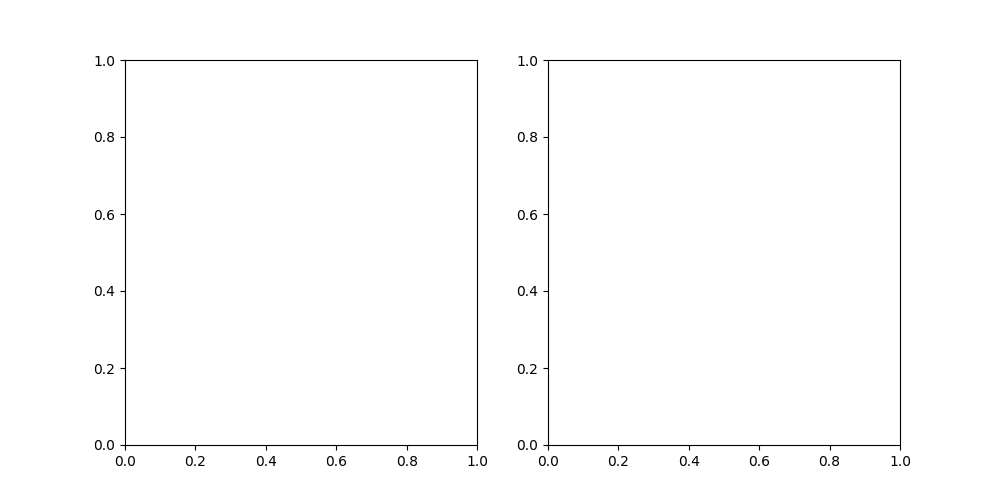

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(output), cmap='gray')
ax[0].set_title('Amplitude')
ax[1].imshow(np.angle(output), cmap='gray')
ax[1].set_title('Phase')
plt.show()


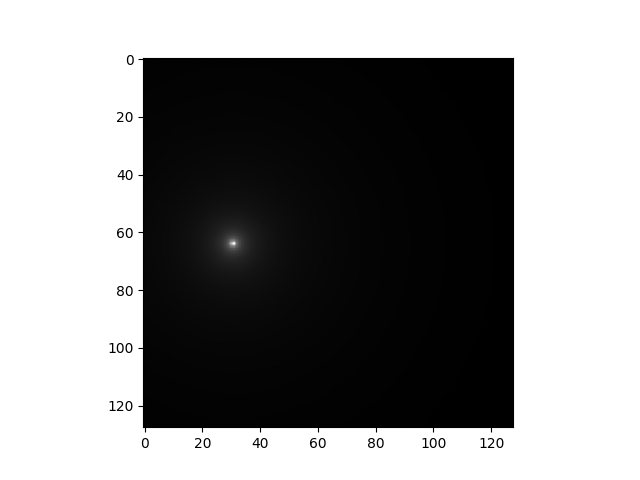

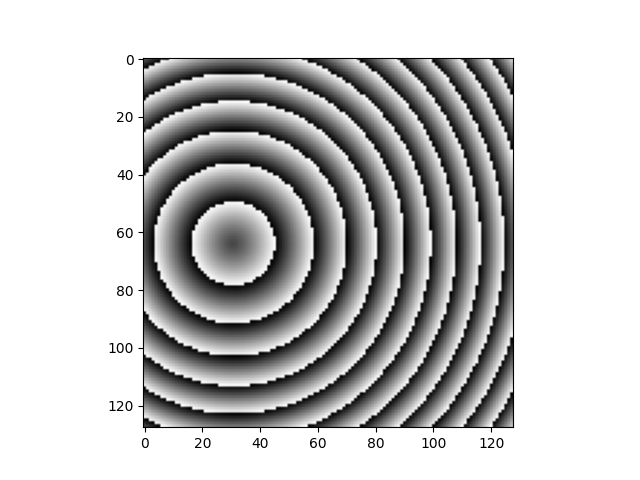

In [ ]:
z_input_aperture = 0.0
z_output_aperture = 0.0

n_rays = Detector.det_shape[0]
x_input, y_input = 1e-7, 0.
dx_input, dy_input = solve_slopes_vmap(x_input, y_input, x_det, y_det)

output_rays_x = jax_poly_x(x_input, y_input, dx_input, dy_input)
output_rays_y = jax_poly_y(x_input, y_input, dx_input, dy_input)
output_rays_dx = jax_poly_dx(x_input, y_input, dx_input, dy_input)
output_rays_dy = jax_poly_dy(x_input, y_input, dx_input, dy_input)

amp = amplitude(x_input, y_input, dx_input, dy_input)
opl = jax_poly_opl(x_input, y_input, dx_input, dy_input)
phase = (2*jnp.pi*(opl/wavelength) + jnp.pi) % (2*jnp.pi) - jnp.pi
phase = phase.reshape((x_det_shape, y_det_shape))
amp = amp.reshape((x_det_shape, y_det_shape))

wave = jnp.exp(1j*phase) * amp * dx * dy

plt.figure()
plt.imshow(np.abs(wave), cmap='gray')
plt.show()

plt.figure()
plt.imshow(np.angle(wave), cmap='gray')
plt.show()
# input_aperture_rays_x = input_rays_x + dx_input * abs(z_init)
# input_aperture_rays_y = input_rays_y + dy_input * abs(z_init)

# output_aperture_rays_x = output_rays_x + output_rays_dx * -z_image
# output_aperture_rays_y = output_rays_y + output_rays_dy * -z_image


# plt.figure()
# plt.plot([z_init, z_input_aperture], [input_rays_x[:n_rays], input_aperture_rays_x[:n_rays]], 'r-')
# plt.plot([z_input_aperture, z_image], [output_aperture_rays_x[:n_rays], output_rays_x[:n_rays]], 'b-')
# plt.plot(np.full(det_coords[:n_rays, 0].shape, z_image), det_coords[:n_rays, 0], 'k.')